## Data Augmentation for Bounding Boxes

In this notebook, we adapted image augmentation techniques to object detection tasks. We implemented rotation, width and height shift, and scaling of images as well as bounding boxes using OpenCV's affine transformation features. We assumed only one object (bounding box) per image.

**Dependencies**

In [1]:
import numpy as np
import cv2

import utils as u

%matplotlib inline

We used dictionaries to facilitate "tests". The method in this cell apply the transformation passed as parameter. This operation is realized $n$ times. For each time, it generate a random factor (angle, scale factor, etc) according to specified in dictionary.

In [9]:
t_dic = { "rotation":rotate_image, "width_shift":width_shift_image, "height_shift":height_shift_image, "scale": scale_image }
f_dic = { "rotation":(0, 90), "width_shift":(0, 0.5), "height_shift":(0, 0.5), "scale": (0.5, 1.5)}

'''
Apply the specidied transdormation n times
return: a list with all transformated images, it bounding box and the value factor used.
'''
def apply_transformation( image, bounding_box, transformation, n ):
    
    import random
    
    t_images_list = []
    
    for i in range(0, n):
        interval = f_dic[transformation]
        factor = random.uniform(interval[0], interval[1])
        img, bb = t_dic[transformation]( image, factor, bounding_box )
        t_images_list.append( (img, bb, factor) )

    return t_images_list
    

**The original image and corresponding bouding box**

In [10]:
image_path = "../Data/Test/Guarana/10.jpg"

original_boundingbox = [57, 57, 140, 209]

Visualizing original image and bouding box

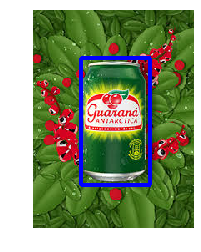

In [12]:
original_image = u.read_image( image_path )
u.show_image( u.draw_boundingbox( original_image, 
                             (original_boundingbox[0], original_boundingbox[1]),
                             (original_boundingbox[2], original_boundingbox[3])  ) )

### Rotation

In [5]:
'''
Rotate image and compute new bounding box
@param image - image to be rotated
@param angle - rotation angle
@param bounding_box - original bounding box
@return: the rotated image and the new bounding box
'''
def rotate_image( image, angle, bounding_box ):
    
    # get image dimension
    img_height, img_width = image.shape[:2]
    
    # get rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D( center = (img_width // 2, img_height // 2), angle = angle, scale = 1.0 )
   
    # apply transformation (ratate image) 
    rotated_image = cv2.warpAffine( image, rotation_matrix, (img_width, img_height) )
    
    # --- compute new bounding box ---
    # Apply same transformation to the four bounding box corners
    rotated_point_A = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[1], 1] ).T )   
    rotated_point_B = np.matmul( rotation_matrix, np.array( [bounding_box[2], bounding_box[1], 1] ).T )   
    rotated_point_C = np.matmul( rotation_matrix, np.array( [bounding_box[2], bounding_box[3], 1] ).T )   
    rotated_point_D = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[3], 1] ).T )   
    # Compute new bounding box, that is, the bounding box for rotated object
    x = np.array( [ rotated_point_A[0], rotated_point_B[0], rotated_point_C[0], rotated_point_D[0] ] )
    y = np.array( [ rotated_point_A[1], rotated_point_B[1], rotated_point_C[1], rotated_point_D[1] ] )
    new_boundingbox = [np.min( x ).astype(int), np.min( y ).astype(int), np.max( x ).astype(int), np.max( y ).astype(int)]
    
    return rotated_image, new_boundingbox

**Applying rotation transformation and visualizing results**

In [14]:
rotated_images = apply_transformation( original_image, original_boundingbox, "rotation", 16 )

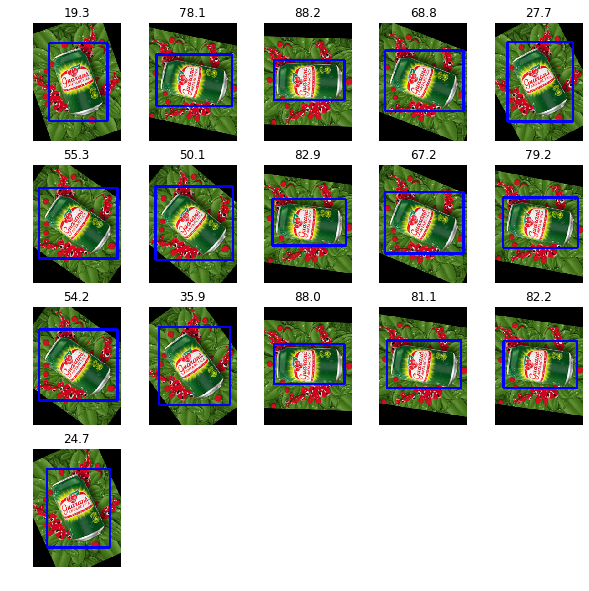

In [15]:
u.plot_images( rotated_images )

### Width shift

In [6]:
def width_shift_image( image, width_shift_range, boundingbox ):
    
    img_height, img_width = image.shape[:2]
    factor = img_width * width_shift_range
    
    M = np.float32([[1,0,factor],[0,1,0]]) 
    shifted_image = cv2.warpAffine( image, M, (img_width, img_height) )
    
    # compute new bounding box    
    shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
    shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   
    
    new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int), 
                        shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]
    
    return shifted_image, new_boundingbox

**Applying width shift transformation and visualizing results**

In [16]:
w_shifted_images = apply_transformation( original_image, original_boundingbox, "width_shift", 16 )

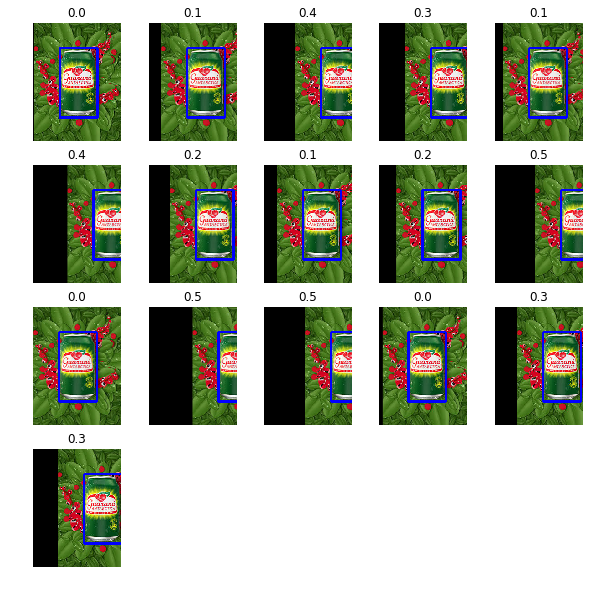

In [17]:
u.plot_images( w_shifted_images )

### Height shift

In [7]:
def height_shift_image( image, height_shift_range, boundingbox ):
    
    img_height, img_width = image.shape[:2]
    factor = height_shift_range * img_height
    
    M = np.float32([[1,0,0],[0,1,factor]]) 
    shifted_image = cv2.warpAffine( image, M, (img_width, img_height) )
    
    # compute new bounding box    
    shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
    shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   
    
    new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int), 
                        shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]
    
    return shifted_image, new_boundingbox

**Applying height shift transformation and visualizing results**

In [18]:
h_shifted_images = apply_transformation( original_image, original_boundingbox, "height_shift", 16 )

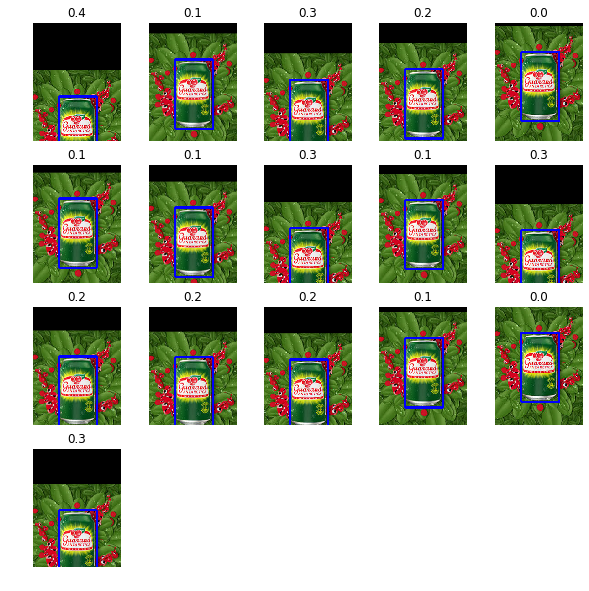

In [19]:
u.plot_images( h_shifted_images )

### Scaling

In [8]:
def scale_image( image, scale_factor, boundingbox ):

    img_height, img_width = original_image.shape[:2]

    width = (int)(scale_factor * img_width)
    height = (int)(scale_factor * img_height)
    
    scaled_img = cv2.resize( image, (width,height) )

    scaling_marix = np.array( [ [scale_factor, 0, 0], [0, scale_factor, 0], [0, 0, scale_factor] ] )

    scaled_point_A = np.matmul( scaling_marix, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
    scaled_point_C = np.matmul( scaling_marix, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   

    new_boundingbox = [ scaled_point_A[0].astype(int), scaled_point_A[1].astype(int), 
                        scaled_point_C[0].astype(int), scaled_point_C[1].astype(int) ]
    
    return scaled_img, new_boundingbox

**Applying scale transformation and visualizing results**

In [20]:
scaled_images = apply_transformation( original_image, original_boundingbox, "scale", 16 )

In [21]:
o_h, o_w = original_image.shape[:2]
for img in scaled_images:
    h, w = img[0].shape[:2]
    print( "Original size:", (o_w, o_h),  "  New size:", (w, h) )

Original size: (193, 261)   New size: (188, 254)
Original size: (193, 261)   New size: (200, 271)
Original size: (193, 261)   New size: (96, 130)
Original size: (193, 261)   New size: (172, 233)
Original size: (193, 261)   New size: (183, 247)
Original size: (193, 261)   New size: (285, 386)
Original size: (193, 261)   New size: (180, 243)
Original size: (193, 261)   New size: (204, 276)
Original size: (193, 261)   New size: (219, 297)
Original size: (193, 261)   New size: (108, 146)
Original size: (193, 261)   New size: (288, 390)
Original size: (193, 261)   New size: (258, 350)
Original size: (193, 261)   New size: (100, 136)
Original size: (193, 261)   New size: (169, 229)
Original size: (193, 261)   New size: (170, 230)
Original size: (193, 261)   New size: (149, 201)


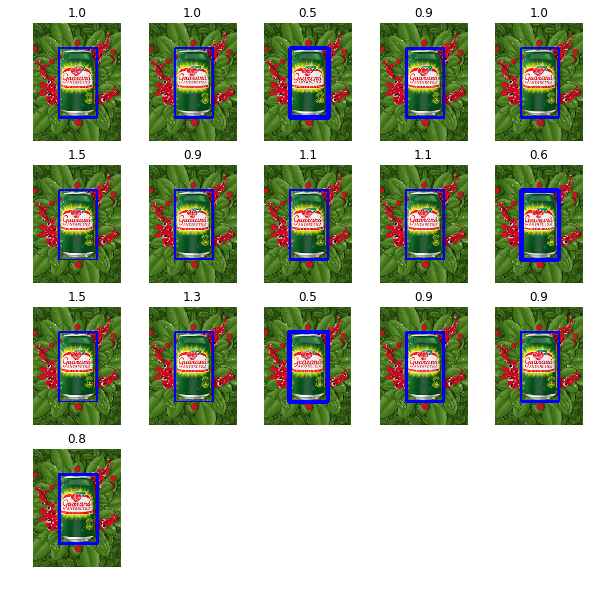

In [22]:
u.plot_images( scaled_images )

### Reference:

* [Geometric Transformations of Images - OpenCv](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html)
* [Data Augmentation for Bounding Boxes: Rotation and Shearing](https://blog.paperspace.com/data-augmentation-for-object-detection-rotation-and-shearing/)